# 광고 클릭 예측 모델 만들기 로지스틱 회귀

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# np.exp ==> 지수
def sigmoid(z):
    return 1.0 / (1+np.exp(-z))

Text(0, 0.5, 'y(z)')

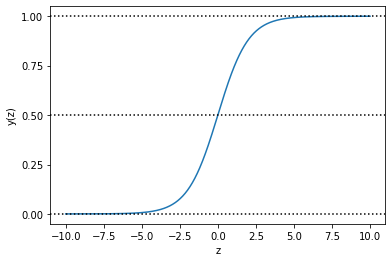

In [3]:
# 시그모이드 함수 그리기
z = np.linspace(-10, 10, 1000)
y = sigmoid(z)
plt.plot(z, y)
plt.axhline(y=0, linestyle=':', color='black')
plt.axhline(y=0.5, linestyle=':', color='black')
plt.axhline(y=1, linestyle=':', color='black')
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel('z')
plt.ylabel('y(z)')

### 데이터 준비

In [4]:
# 트레이닝 정리
train_df = pd.read_csv("C:/Users/Yoo/Documents/Study/Bigdata center/data/advertisement/train.csv", nrows=100000)
unused_cols, label_col = ["id", "hour", "device_id", "device_ip"], "click"
train_df = train_df.drop(unused_cols, axis=1)
X_dict_train = list(train_df.drop(label_col, axis=1).T.to_dict().values()) # 딕셔너리 변환
y_train = train_df[label_col]

In [5]:
# 테스트 정리
test_df = pd.read_csv("C:/Users/Yoo/Documents/Study/Bigdata center/data/advertisement/train.csv", header=0, skiprows=(1, 100000), nrows=100000)
test_df = test_df.drop(unused_cols, axis=1)
X_dict_test = list(test_df.drop(label_col, axis=1).T.to_dict().values())
y_test = test_df[label_col]

In [6]:
# 원 핫 인코딩 벡터 변환(sparse True 미실행시 메모리 문제 발생)(training은 fit 해줘야 함)
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform(X_dict_train)
X_test = vectorizer.transform(X_dict_test)

### 그리드 서치를 이용한 로지스틱 회귀 모델 학습

In [7]:
# penalty(규제) ==> l1,l2 // C ==> 규제의 정도(0에 가까울수록 규제 강해짐)
from sklearn.linear_model.logistic import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# 그리드 서치(n_jobs ==> cpu 코어 사용 개수)
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.01, 0.1, 1, 10, 100], "penalty": ["l1", "l2"]}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=3, scoring="roc_auc")
grid_search.fit(X_train, y_train)

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [9]:
# 최적의 하이퍼파라미터 값
grid_search.best_params_

{'C': 100, 'penalty': 'l2'}

### 로지스틱 회귀 모델의 성능 측정: 정확도, 혼동행렬, ROC의 AUC

In [10]:
# 하이퍼파라미터 값 저장
clf_best = grid_search.best_estimator_

In [11]:
y_pred = clf_best.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [12]:
# 카운팅 해보기
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([99674,   326], dtype=int64))

In [13]:
# 정확도(주의 실측값, 예측값 순서로 작성할 것)
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

accuracy_score(y_test, y_pred)

0.82396

In [14]:
# 혼동행렬
confusion_matrix(y_test, y_pred)

array([[82290,   220],
       [17384,   106]], dtype=int64)

In [15]:
# ROC 커브 확률값
y_pred_proba = clf_best.predict_proba(X_test)[:,1] # 두번째 열 가져오기(양성확률)
y_pred_proba

array([0.1534487 , 0.15344184, 0.15342606, ..., 0.18167911, 0.18614206,
       0.09836745])

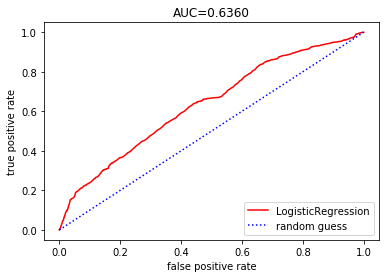

In [16]:
# ROC, AUC 그리기
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, "r-", label="LogisticRegression")
plt.plot([0, 1], [0, 1], "b:", label="random guess")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title("AUC={:.4f}".format(auc))
plt.legend(loc='lower right')